In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as so
import warnings

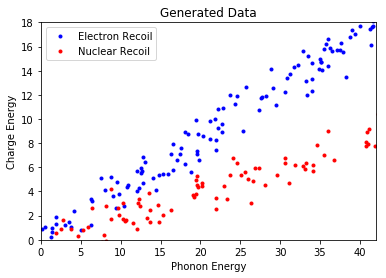

C:\Users\zecco\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in sqrt
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:571: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:582: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:587: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
C:\Users\zecco\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:575: RuntimeWarning: invalid value encountered in less
  if fxe < fxr:


NameError: name 'f' is not defined

In [2]:
#Parameters
alphaP = 1
betaP  = 0
gammaP = 0
alphaQ = 1
betaQ  = 0
gammaQ = 0
eps    = .003
V      = .004
F0      = .3
lam    = 100 #in keV
lamN   = 18   #in keV
a      = .16
b      = .18
weight0 = .3

#Sample Size
J = 1000

def FanoE(Er):
    return F0

def FanoN(Er):
    return .87*Er

#Data Generation
EPdataE = []
EQdataE = []
EPdataN = []
EQdataN = []
ErdataE = []
ErdataN = []

for j in range(int(np.floor(J*(1-weight0)))):
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(FanoE(Er)*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE.append(Er)
    EPdataE.append(EP)
    EQdataE.append(EQ)

for j in range(int(np.floor(J*weight0))):
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(FanoN(Er)*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN.append(Er)
    EPdataN.append(EP)
    EQdataN.append(EQ)
"""
density = True
bins = 100
exphist, bin_edges = np.histogram(ErdataN, bins, density=density)  

plt.plot(bin_edges[0:-1],exphist, drawstyle = "steps-mid", color="red")
plt.show()
"""

#Pseudo-Analytic Solution #1    
def fvarFv(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvarFvN(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

def fvarFv_exp(p0, q0, x0, F=lambda Er:F0):
    stdP = np.sqrt(alphaP+betaP*(x0)+gammaP*((x0)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F(x0)*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    ans = -((bv**2)/(4*av)-cv)
    return ans

def fvarFvN_exp(p0, q0, x0, F=lambda Er:F0):
    x0Y = a*(np.absolute(x0)**(b))*x0
    stdP = np.sqrt(alphaP+betaP*(x0+x0Y*V/eps)+gammaP*((x0+x0Y*V/eps)**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0Y+gammaQ*(x0Y**2))
    stdN = np.sqrt(F(x0)*x0Y/eps)
    meanN = x0Y/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    ans = -((bv**2)/(4*av)-cv)
    return ans

fvarF = lambda x0, p0, q0: fvarFv(p0,q0,x0,FanoE)
fvarFN = lambda x0, p0, q0: fvarFvN(p0,q0,x0,FanoN)
fvarF_exp = lambda x0, p0, q0: fvarFv_exp(p0,q0,x0,FanoE)
fvarFN_exp = lambda x0, p0, q0: fvarFvN_exp(p0,q0,x0,FanoN)

def FvarFE(p0,q0):
    Er0 = p0-(V*q0/eps)
    loc = so.fmin(fvarF_exp,x0 = np.absolute(Er0)+1, args=(p0,q0), disp = False)
    #W0 = #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(-1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(f, minx, maxx, args = (p0,q0,F,))[0]
    return ans

def FvarFN(p0,q0):
    Er0 = p0-(V*q0/eps)
    Er0Y = a*(np.absolute(Er0)**(b))*Er0
    loc = so.fmin(fvarFN_exp,x0 = np.absolute(Er0Y)+1, args=(p0,q0), disp = False)
    #W0 = fvN_expD2(p0,q0,loc,F) #second derivative of fvN_exp at Er=loc
    sca = 10 #np.sqrt(1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(fvarFN, minx, maxx, args = (p0,q0,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    #print(ans)
    return ans

def FvarFNE(p0,q0,weight=weight0):
    ans = FvarFN(p0,q0)*weight+(1-weight)*FvarFE(p0,q0)
    return ans

#Graphing (Electron vs Nuclear Generated Data)
xE = EPdataE
yE = EQdataE
xN = EPdataN
yN = EQdataN

plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
#plt.ylim(0,100)
#plt.xlim(0,100*(1+V/eps))
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.title("Generated Data")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.legend()
plt.show()

#Graphing (Electron Recoil, Pseudo-Analytic vs Data Generation)
minP = 0  #min(xE)
minQ = 0  #min(yE)
maxP = 20*(1+V/eps)  #max(xE)
maxQ = 20  #max(yE)
stepNo = 25
stepP = (maxP-minP)/stepNo
stepQ = (maxQ-minQ)/stepNo
p1 = np.arange(minP, maxP, stepP)
q1 = np.arange(minQ, maxQ, stepQ)
pp1, qq1 = np.meshgrid(p1, q1, sparse=True)

zzE = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzN = [[0 for x in range(len(q1))] for y in range(len(p1))]
zzNE = [[0 for x in range(len(q1))] for y in range(len(p1))]

count1 = 0
for ppp1 in p1:
    count2 = 0
    for qqq1 in q1:
        zzE[count2][count1] = FvarFE(ppp1,qqq1)
        zzN[count2][count1] = FvarFN(ppp1,qqq1)
        zzNE[count2][count1] = FvarFNE(ppp1,qqq1,weight0)
        count2+=1
    count1+=1


#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.ylabel("Charge Energy")
plt.xlabel("Phonon Energy")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zzN, cmap='coolwarm',alpha=.3)
plt.plot(xN,yN,'b.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.show()

plt.contour(p1,q1,zzN)
plt.contour(p1,q1,zzE)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/figureVF1.png')
plt.show()

plt.contourf(p1,q1,zzNE, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,18)
plt.xlim(0,18*(1+V/eps))
plt.tight_layout()
plt.savefig('figures/figureVF2.png')
plt.show()